In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib

In [2]:
df = pd.read_csv('dataset/cleaned_2016_tripdata.csv')

In [3]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

In [4]:
df_demand = df.groupby([
    pd.Grouper(key='tpep_pickup_datetime', freq='h'),
    'cluster',
    'location'
]).size().reset_index(name='trip_count')

In [5]:
df_demand['hour'] = df_demand['tpep_pickup_datetime'].dt.hour
df_demand['day'] = df_demand['tpep_pickup_datetime'].dt.day
df_demand['weekday'] = df_demand['tpep_pickup_datetime'].dt.weekday
df_demand['month'] = df_demand['tpep_pickup_datetime'].dt.month

In [6]:
for lag in [1, 24, 168]:  # 1hr, 1day, 1week
    df_demand[f'lag_{lag}'] = df_demand.groupby('cluster')['trip_count'].shift(lag)

In [7]:
df_demand['rolling_mean_24'] = df_demand.groupby('cluster')['trip_count'].shift(1).rolling(24).mean()

In [8]:
df_demand['location_encoded'] = df_demand['location'].astype('category').cat.codes
df_demand = df_demand.sort_values('tpep_pickup_datetime')
df_demand = df_demand.dropna().copy()

In [9]:
features = [
    'hour', 'day', 'weekday', 'month',
    'cluster', 'location_encoded',
    'lag_1', 'lag_24', 'lag_168', 'rolling_mean_24'
]
X = df_demand[features]
y = df_demand['trip_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [10]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=12,
    random_state=42,
    n_jobs=-1
)

In [11]:
rf_model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [12]:
# Save Model
joblib.dump(rf_model, 'random_forest_ride_hailing_model.pkl')

['random_forest_ride_hailing_model.pkl']

In [13]:
# Load Model
model = joblib.load('random_forest_ride_hailing_model.pkl')

In [14]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAE : {mae:.2f}")
print(f"R²  : {r2:.4f}")

RMSE: 124.97
MAE : 79.24
R²  : 0.9817


In [15]:
test_indices = X_test.index
test_full = df_demand.loc[test_indices].copy()
test_full['predicted'] = y_pred

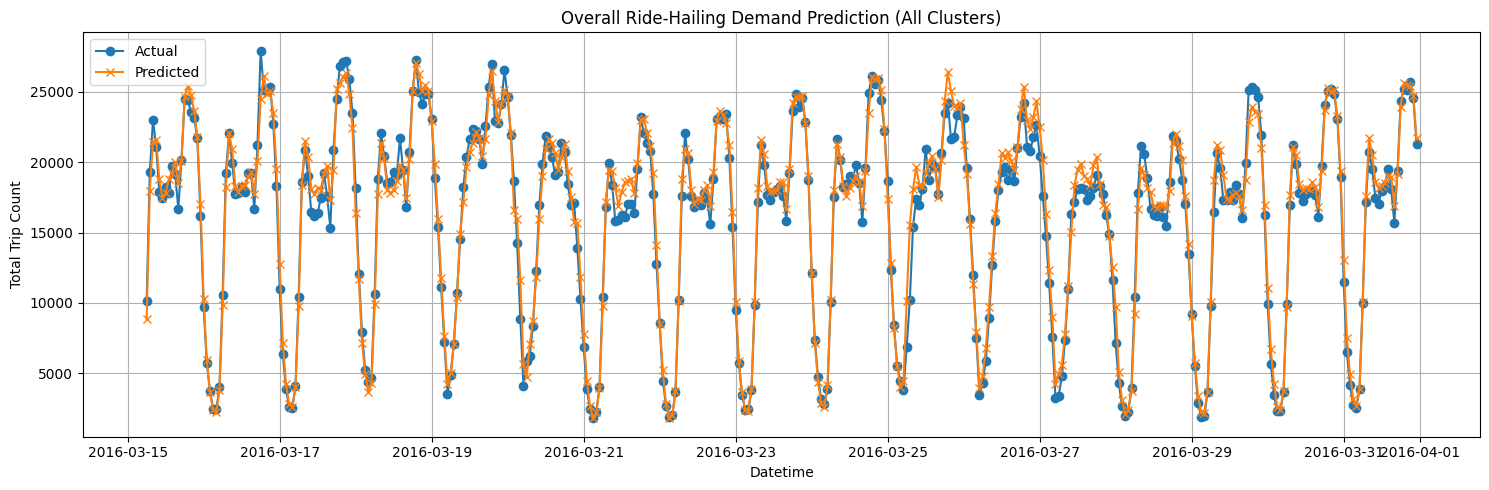

In [16]:
overall_grouped = test_full.groupby('tpep_pickup_datetime')[['trip_count', 'predicted']].sum().reset_index()

plt.figure(figsize=(15, 5))
plt.plot(overall_grouped['tpep_pickup_datetime'], overall_grouped['trip_count'], label='Actual', marker='o')
plt.plot(overall_grouped['tpep_pickup_datetime'], overall_grouped['predicted'], label='Predicted', marker='x')
plt.title('Overall Ride-Hailing Demand Prediction (All Clusters)')
plt.xlabel('Datetime')
plt.ylabel('Total Trip Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

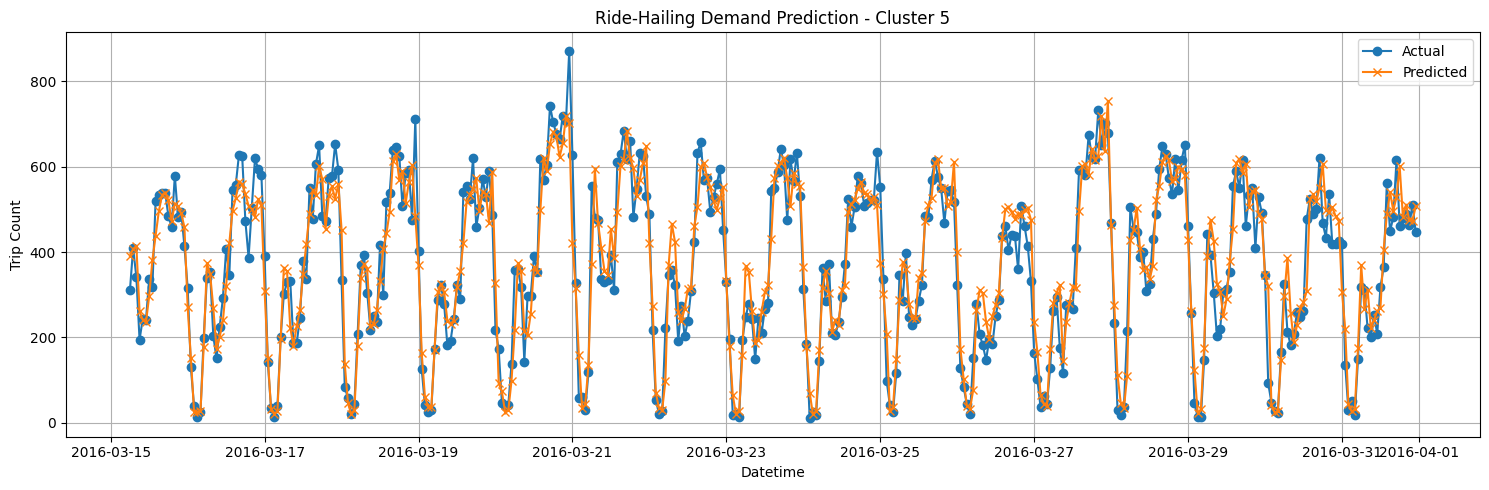

In [17]:
sample_cluster = test_full[test_full['cluster'] == 1]

plt.figure(figsize=(15, 5))
plt.plot(sample_cluster['tpep_pickup_datetime'], sample_cluster['trip_count'], label='Actual', marker='o')
plt.plot(sample_cluster['tpep_pickup_datetime'], sample_cluster['predicted'], label='Predicted', marker='x')
plt.title('Ride-Hailing Demand Prediction - Cluster 5')
plt.xlabel('Datetime')
plt.ylabel('Trip Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()